Notebook to compare mean outgoing longwave radiation at toa from NextGEMS simulations (using Low Resolution Archive) with ERA5 eanalysis data

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from aqua import Reader, catalogue
catalogue();

IFS	tco3999-ng5	2.8km experiment, coupled with FESOM
	- ICMGG_atm2d	original 2d output
	- ICMU_atm2d	original 2d output (lnsp)
	- ICMU_atm3d	original 3d output
	- interpolated_global	NN interpolation to 5400x2700 grid (lon=[-180,180], lat=[-90, 90])
IFS	tco2559-ng5	4km experiment, coupled with FESOM
	- ICMGG_atm2d	original 2d output
	- ICMU_atm2d	original 2d output (lnsp)
	- ICMU_atm3d	original 3d output
	- interpolated_global	NN interpolation to 5400x2700 grid (lon=[-180,180], lat=[-90, 90])
	- lra-r100-mon	LRA monthly data 1x1 deg regular grid
IFS	tco1279-orca025	9km baseline, coupled to NEMO, deep conv ON
	- ICMGG_atm2d	original 2d output
	- ICMU_atm2d	original 2d output (lnsp)
	- ICMU_atm3d	original 3d output
	- lra-r100-mon	LRA monthly data 1x1 deg regular grid
IFS	test-tco2559	4km experiment, coupled with FESOM
	- ICMGG_atm2d	2d output
	- ICMU_atm3d	3d output
IFS	test-tco79	TCO79 test data
	- short	original 2d output
	- long	coarse IFS data 1y

FESOM	tco3999-ng5	2.5km experiment,

Import slurm

In [1]:
from aqua.slurm import slurm
slurm.job(cores=8, memory="50 GB", jobs=1, queue = "interactive", walltime='00:30:00')

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p interactive
#SBATCH -A bb1153
#SBATCH -n 1
#SBATCH --cpus-per-task=8
#SBATCH --mem=47G
#SBATCH -t 00:30:00
#SBATCH --error=./slurm/logs/dask-worker-%j.err
#SBATCH --output=./slurm/output/dask-worker-%j.out

/work/bb1153/b382216/mambaforge/envs/aqua/bin/python -m distributed.cli.dask_worker tcp://136.172.124.7:45503 --nthreads 2 --nworkers 4 --memory-limit 11.64GiB --name dummy-name --nanny --death-timeout 60



In [2]:
slurm.squeue()

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           5231577 interacti dask-wor  b382216  R       0:05      1 l40049


0

Explore the CERES catalogue (CERES is used as reference to compare models)

In [ ]:
reader = Reader(model="CERES", exp="ebaf-toa42", source="monthly")
data = reader.retrieve()
data

Now load NextGems data from LRA and observations (CERES)

Text(0.5, 1.0, 'global mean top net thermal radiation flux')

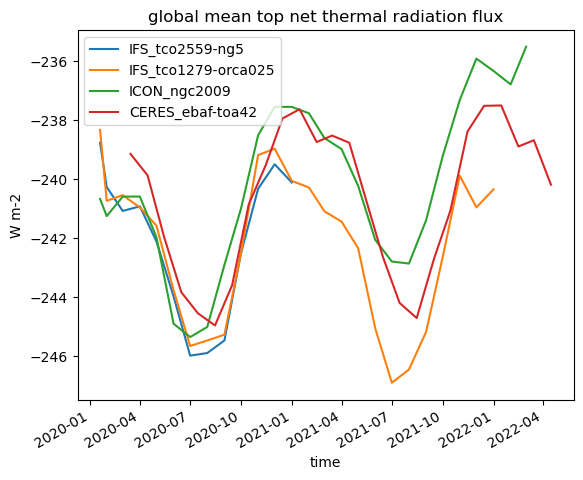

In [5]:
model_list = ["IFS", "ICON", "CERES"]
exp_name = {"IFS": ["tco2559-ng5","tco1279-orca025"], "ICON": ["ngc2009"], "CERES": ["ebaf-toa42"]}
source = {"IFS": ["lra-r100-mon"], "ICON": ["lra-r100-mon"], "CERES": ["monthly"]}

# sign of flux is opposite in CERES data
data = {}
for model in model_list:
    for exp in exp_name[model]:
        for src in source[model]:
            if model=="CERES":
                reader = Reader(model=model, exp=exp, source=src, regrid="r100")
                data[(model, exp)] = reader.retrieve()["toa_lw_all_mon"]
                data[(model, exp)] = data[(model, exp)][240:266]*-1
            else:
                reader = Reader(model=model, exp=exp, source=src, regrid="r100")
                data[(model, exp)] = reader.retrieve()["mtntrf"]

plt.figure()
for model in model_list:
    for exp in exp_name[model]:
        reader.fldmean(data[(model, exp)]).plot(label=f"{model}_{exp}")
plt.legend()
plt.ylabel("W m-2")
plt.title("global mean top net thermal radiation flux")